<a href="https://colab.research.google.com/github/Aditib2409/EE-660---Machine-Learning-II/blob/main/Final%20Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.ensemble import RandomForestClassifier

In [3]:
def loaddata(tr_path, ts_path):
    tr_data = pd.read_csv(tr_path, delimiter=',', skiprows=24, header=None)
    ts_data = pd.read_csv(ts_path, delimiter=',', skiprows=24, header=None)
    # print(ts_data)
    y_tr = tr_data[19]
    y_tr = y_tr.astype(str).str.lstrip(' ')
    x_tr = tr_data.drop(columns=19, inplace=False, axis=1)
    y_ts = ts_data[19]
    y_ts = y_ts.astype(str).str.lstrip(' ')
    x_ts = ts_data.drop(columns=19, inplace=False, axis=1)
    return x_tr, y_tr, x_ts, y_ts

In [4]:
train_path = '/content/sample_data/segment-ssl40-10-1tra.dat'
test_path = '/content/sample_data/segment-ssl40-10-1tst.dat'

In [5]:
x_train, y_train, x_test, y_test = loaddata(train_path, test_path)

In [6]:
features = ['Region Centroid col', 'Region Centroid row', 'Region pixel count', 'Short line density 5', 'Short line density 2', 'Vedge mean', 'Vedge sd', 'Hedge mean', 'Hedge sd', 'Intensity mean',
            'Rawred mean', 'Rawblue mean', 'Rawgreen mean', 'Exred mean', 'Exblue mean', 'Exgreen mean', 'Value mean', 'Saturation mean', 'Hue mean']
x_train.columns = features
x_test.columns = features

# Target variable distribution
Most of the data is unlabeled as seen from the distribution below

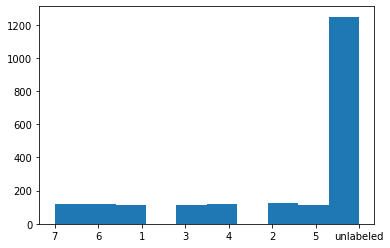

In [7]:
n, bins, patches = plt.hist(y_train)

# PCA

## Extracting the principal Components Step by Step

In [8]:
# extract labeled training data
x_train_labeled = x_train[y_train != 'unlabeled']
y_train_labeled = y_train[y_train != 'unlabeled']

# standardize the features
sc = StandardScaler()
x_train_std = sc.fit_transform(x_train_labeled)
x_test_std = sc.fit_transform(x_test)

In [9]:
cov_mat = np.cov(x_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

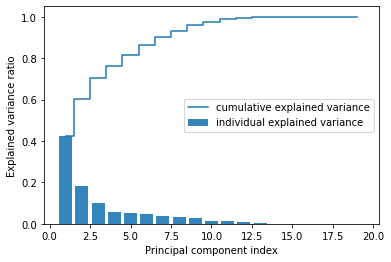

In [10]:
# calculate cummulative sum of explained variances
tot = sum(eigen_vals)
var_exp = [(i/tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
# print(len(var_exp), len(cum_var_exp))
# plot explained variances
plt.bar(range(1, 20), var_exp, alpha=0.9, align='center', label='individual explained variance')
plt.step(range(1, 20), cum_var_exp, where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

From the above plot, we can infer that the first principal componenet alone accounts for more than 40% of the variance. And the first two principal components together account for almost 60% of the variance in the training dataset.

## Feature Transformation

Transform the training dataset onto the new principal component axes.

In [11]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

# sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [12]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[-0.0277997   0.00822164]
 [ 0.20354244 -0.03250712]
 [ 0.          0.        ]
 [ 0.02262931  0.03130222]
 [ 0.0076441  -0.26571051]
 [-0.01961478 -0.44704596]
 [-0.02195547 -0.4917111 ]
 [-0.02166828 -0.47820921]
 [-0.02390189 -0.49651217]
 [-0.35189089  0.03437269]
 [-0.34900979  0.03951742]
 [-0.35792828  0.02758683]
 [-0.34367558  0.03710243]
 [ 0.30785405  0.02055015]
 [-0.32704977 -0.01848683]
 [ 0.24028355  0.01045398]
 [-0.35516137  0.03008365]
 [ 0.21403537 -0.00157901]
 [ 0.17898702  0.06159465]]


Using this projection matrix, we can now transform a sample X onto the PCA subspace (the principal components one and two) obtaining x', now a two-dimensional sample vector consisting of new features.

In [13]:
x_train_std[0].dot(w)
x_train_pca = x_train_std.dot(w)

Nw let us visulaize the training set, now stored as an N x 2-dimensional matrix, in a two-dimensional scatterplot:

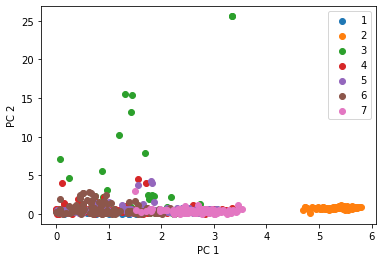

In [14]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
markers = ['o', 'o', 'o', 'o', 'o', 'o', 'o']
for l, c, m in zip(np.unique(y_train_labeled), colors, markers):
    plt.scatter(np.abs(x_train_pca[y_train_labeled==l, 0]),
                np.abs(x_train_pca[y_train_labeled==l, 1]),
                c=c, label=l, marker=m)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='upper right')
plt.show()

As seen from the above plot, the training data is a challenging data as the classes are not explicitly distinguished across the dataset by using a linear classifier. The class '3' has a lot of outliers as seen from the plot. Most of the data is more spread along the the first principal component than the second principal componenet, which is consistent with the explained variance ratio plot that we created previously. 

In [15]:
scores, selected_feat = [], []
clf = RandomForestClassifier(max_depth=2, random_state=0)
for k in range(1, 20):
    sfs1 = sfs(clf, k_features=k, forward=True, verbose=2, scoring='accuracy')
    sfs1 = sfs1.fit(x_train_labeled, y_train_labeled)
    scores.append(sfs1.k_score_)
selected_feat.append(sfs1.k_feature_names_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:   13.4s finished

[2022-11-27 02:58:06] Features: 1/1 -- score: 0.5427386191472476[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:   13.2s finished

[2022-11-27 02:58:19] Features: 1/2 -- score: 0.5427386191472476[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   12.7s finished

[2022-11-27 02:58:31] Features: 2/2 -- score: 0.7364764447009595[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 

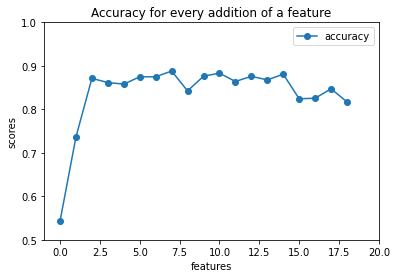

Number of features that gave a maximum sccuracy of 0.8881 = 8


In [16]:
plt.plot(range(0, 19), scores, marker='o', label='accuracy')
plt.xlim([-1, 20])
plt.ylim([0.5, 1])
plt.legend(loc='upper right')
plt.title(f'Accuracy for every addition of a feature')
plt.xlabel(f'features')
plt.ylabel(f'scores')
plt.show()
max_features = np.argmax(scores) + 1
print(f'Number of features that gave a maximum sccuracy of {np.max(scores):.4f} = {max_features}')

After 8 features, the accuracy of the model slowly goes down and becomes more erratic. The highest accuracy was achieved for a total of 8 features. The following peice of code gives the 8 best selected features.

Therefore, now we set the value of k = 8

In [17]:
scores, selected_feat = [], []
clf = RandomForestClassifier(max_depth=2, random_state=0)
for k in range(1, max_features+1):
    sfs1 = sfs(clf, k_features=k, forward=True, verbose=2, scoring='accuracy')
    sfs1 = sfs1.fit(x_train_labeled, y_train_labeled)
    scores.append(sfs1.k_score_)
selected_feat.append(sfs1.k_feature_names_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:   13.2s finished

[2022-11-27 03:29:57] Features: 1/1 -- score: 0.5427386191472476[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:   16.5s finished

[2022-11-27 03:30:13] Features: 1/2 -- score: 0.5427386191472476[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   12.5s finished

[2022-11-27 03:30:26] Features: 2/2 -- score: 0.7364764447009595[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 

In [18]:
selected_feat

[('Region Centroid col',
  'Region Centroid row',
  'Region pixel count',
  'Intensity mean',
  'Rawred mean',
  'Rawblue mean',
  'Exblue mean',
  'Hue mean')]